In [1]:
!pip install -q ray
!pip install -q xgboost==2.0.3 xgboost_ray==0.1.19


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import ray
# ray.shutdown()
ray.init(ignore_reinit_error=True)
ray.available_resources()

2025-08-30 09:51:27,252	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-08-30 09:51:33,364	INFO worker.py:1771 -- Started a local Ray instance.


{'CPU': 12.0,
 'object_store_memory': 2147483648.0,
 'node:__internal_head__': 1.0,
 'memory': 4997518951.0,
 'node:127.0.0.1': 1.0}

## Logistic regression

In [3]:
import xgboost as xgb
import numpy as np
from xgboost_ray import RayDMatrix, RayParams, predict, train

x = np.array(range(1000)).reshape(-1, 1)
y = x.flatten() < 500

train_set = RayDMatrix(x, y)

evals_result = {}
bst = train(
    {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "error"],
    },
    train_set,
    num_boost_round=10,
    evals_result=evals_result,
    evals=[(train_set, "train")],
    verbose_eval=False,
    ray_params=RayParams(num_actors=2, cpus_per_actor=1, gpus_per_actor=0))

bst.save_model("model.xgb")
print("Final training error: {:.4f}".format(
    evals_result["train"]["error"][-1]))

(raylet) [2025-08-30 09:51:42,239 E 12667 1546480] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-08-30_09-51-27_411810_12308 is over 95% full, available space: 9318305792; capacity: 250685575168. Object creation will fail if spilling is required.
2025-08-30 09:51:48,720	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-08-30 09:51:50,474	INFO main.py:1140 -- [RayXGBoost] Created 2 new actors (2 total actors). Waiting until actors are ready for training.
(raylet) [2025-08-30 09:51:52,260 E 12667 1546480] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-08-30_09-51-27_411810_12308 is over 95% full, available space: 9313808384; capacity: 250685575168. Object creation will fail if spilling is required.
2025-08-30 09:51:54,968	INFO main.py:1191 -- [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=12931) [09:51:55] task 

Final training error: 0.0000


/usr/local/anaconda3/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [09:51:59] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


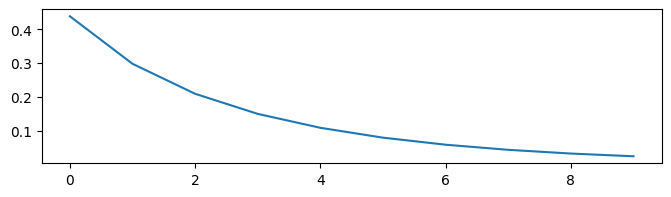

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 2))
plt.plot(evals_result["train"]["logloss"])

## Linear regression

In [5]:
x = np.array(range(1000)).reshape(-1, 1)
y = (x**2 + 10).flatten() # Flatten y to make it 1D

train_set = RayDMatrix(x, y)

evals_result = {}
bst = train(
    {
        "objective": "reg:squarederror",
        "eval_metric": ["rmse"],
        "tree_method": "hist",
        "max_depth": 3,
        "eta": 0.1,
    },
    train_set,
    num_boost_round=500,
    evals_result=evals_result,
    evals=[(train_set, "train")],
    verbose_eval=False,
    ray_params=RayParams(num_actors=2, cpus_per_actor=1, gpus_per_actor=0))

bst.save_model("model.xgb")
print("Final training error: {:.4f}".format(
    evals_result["train"]["rmse"][-1])) # Changed error to rmse based on eval_metric

2025-08-30 09:52:01,252	INFO main.py:1140 -- [RayXGBoost] Created 2 new actors (2 total actors). Waiting until actors are ready for training.
(raylet) [2025-08-30 09:52:02,342 E 12667 1546480] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-08-30_09-51-27_411810_12308 is over 95% full, available space: 9311735808; capacity: 250685575168. Object creation will fail if spilling is required.
2025-08-30 09:52:06,189	INFO main.py:1191 -- [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=13012) [09:52:06] task [xgboost.ray]:7176894512 got new rank 0
2025-08-30 09:52:11,886	INFO main.py:1708 -- [RayXGBoost] Finished XGBoost training on training data with total N=1,000 in 10.70 seconds (5.69 pure XGBoost training time).


Final training error: 1392.9984


/usr/local/anaconda3/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [09:52:11] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


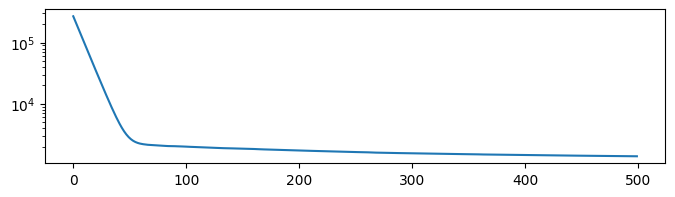

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 2))
plt.yscale("log")
plt.plot(evals_result["train"]["rmse"])

In [19]:
from ray import tune
from ray.tune import PlacementGroupFactory
from xgboost_ray import RayParams, train

ray.shutdown()
ray.init()
x = np.array(range(1000)).reshape(-1, 1)
y = (x**2 + 10).flatten() # Flatten y to make it 1D

train_set = RayDMatrix(x, y)

def objective(params, num_boost_round=1000):
    evals_result = {}
    bst = train(
        params,
        train_set,
        num_boost_round=num_boost_round,
        evals_result=evals_result,
        evals=[(train_set, "train")],
        verbose_eval=False,
        ray_params=RayParams(num_actors=2, cpus_per_actor=1)
    )
    # tune.report({"rmse": evals_result["train"]["rmse"][-1]})
    return {"rmse": evals_result["train"]["rmse"][-1]}

config = {
    "objective": "reg:squarederror",
    "eval_metric": ["rmse"],
    "tree_method": "hist",
    "max_depth": tune.randint(1, 9),
    "min_child_weight": tune.choice([1, 2, 3]),
    "subsample": tune.uniform(0.5, 1.0),
    "eta": tune.loguniform(1e-4, 1e-1),
}

resources_per_trial = PlacementGroupFactory(
    [{"CPU": 1}] + [{"CPU": 2}] * 1
)

tuner = tune.Tuner(
    tune.with_resources(objective, resources=resources_per_trial),
    tune_config=tune.TuneConfig(num_samples=10, max_concurrent_trials=4),
    param_space=config,
)

results = tuner.fit()


(objective pid=19312) [RayXGBoost] Created 2 new actors (2 total actors). Waiting until actors are ready for training.
(raylet) [2025-08-30 10:07:39,237 E 19287 1594363] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-08-30_10-07-26_200899_12308 is over 95% full, available space: 8207097856; capacity: 250685575168. Object creation will fail if spilling is required.
(objective pid=19311) [RayXGBoost] Starting XGBoost training.
(objective pid=19314) [RayXGBoost] Created 2 new actors (2 total actors). Waiting until actors are ready for training. [repeated 3x across cluster]
(_RemoteRayXGBoostActor pid=19363) [10:07:48] task [xgboost.ray]:7221132128 got new rank 0
(raylet) [2025-08-30 10:07:49,298 E 19287 1594363] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-08-30_10-07-26_200899_12308 is over 95% full, available space: 8206553088; capacity: 250685575168. Object creation will fail if spilling is required.
(objective pid=19314) [RayXGBoost] Starting XGBoost training

(raylet) [2025-08-30 10:09:19,784 E 19287 1594363] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-08-30_10-07-26_200899_12308 is over 95% full, available space: 8095825920; capacity: 250685575168. Object creation will fail if spilling is required.


In [20]:
best_result = results.get_best_result(metric="rmse", mode="min")
print(best_result.config)

objective(best_result.config, 500)

2025-08-30 10:09:20,346	INFO main.py:1140 -- [RayXGBoost] Created 2 new actors (2 total actors). Waiting until actors are ready for training.


{'objective': 'reg:squarederror', 'eval_metric': ['rmse'], 'tree_method': 'hist', 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.5275071058863638, 'eta': 0.08226308004817766}


2025-08-30 10:09:24,162	INFO main.py:1191 -- [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=20058) [10:09:24] task [xgboost.ray]:7149488224 got new rank 0
2025-08-30 10:09:29,240	INFO main.py:1708 -- [RayXGBoost] Finished XGBoost training on training data with total N=1,000 in 8.99 seconds (5.07 pure XGBoost training time).


{'rmse': 1284.2058154110255}

(raylet) [2025-08-30 10:09:29,849 E 19287 1594363] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-08-30_10-07-26_200899_12308 is over 95% full, available space: 8095186944; capacity: 250685575168. Object creation will fail if spilling is required.
(raylet) [2025-08-30 10:09:39,912 E 19287 1594363] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-08-30_10-07-26_200899_12308 is over 95% full, available space: 8094883840; capacity: 250685575168. Object creation will fail if spilling is required.
(raylet) [2025-08-30 10:09:49,917 E 19287 1594363] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-08-30_10-07-26_200899_12308 is over 95% full, available space: 8094093312; capacity: 250685575168. Object creation will fail if spilling is required.
(raylet) [2025-08-30 10:09:59,924 E 19287 1594363] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-08-30_10-07-26_200899_12308 is over 95% full, available space: 8094842880; capacity: 250685575168. Object crea

In [21]:
ray.shutdown()